In [1]:
import numpy as np
from scipy import signal
from scipy import fftpack
from matplotlib import pyplot as plt
from crawlab_toolbox import plotting

In [2]:
def create_noisy_signal(
    numPoints, samplingRate, frequencies, amplitudes,
    noiseStDev, phase=0, offset=0,
    frequencyError=0.05, harmonics=1,
    saveSignal=False,fileName='signal'):
    '''
    create_noisy_signal

    Create a signal with desired randomness and spectral qualities.

    Inputs:
        - duration: time (in seconds) captured by the signal
        - samplingRate: rate (in Hz) of the signal
        - frequencies: list of frequencies in the signal
        - amplitudes: amplitudes of the corresponding frequencies
        - (float) noiseStDev: standard deviation squared) of
                the gaussian noise added to the signal
        - (float) frequencyStDev: standard deviation
                of the gaussian noise added to the frequency
        - (float) amplitudeStDev: standard deviation
                of the gaussian noise added to the amplitudes
        - (float) phaseStDev: StDev (standard deviation squared) of
                the gaussian noise added to the phase of the signal

    '''

    # determine the required number of datapoints to cover the duration
    # at the required sampling rate
#     numPoints = int(duration * samplingRate)

    # Create a time array with the correct start and endpoint, sampled at
    # the required sampling rates
#     time = np.atleast_2d(np.linspace(0,duration,numPoints))
    time = np.atleast_2d(np.cumsum(np.ones(numPoints) / samplingRate))

    # Ensure that all of the inputs are cast as numpy arrays
    freqs = np.atleast_2d(np.asarray(frequencies).flatten()).T
    amps = np.atleast_2d(np.asarray(amplitudes).flatten()).T
    noiseStDev = np.asarray(noiseStDev)

    # Modify the signal slightly
    m, n = freqs.shape
#     phase = np.atleast_2d(phaseStDev * np.random.random((m, n)))

    # Create randomly distributed noise with a given standard deviation
    noise = noiseStDev * np.random.random(numPoints)

    # The number of input frequencies must be identical to the number
    # of input amplitudes
    if len(freqs) != len(amps):
        raise ValueError('Length of input frequencies must be identical to\
                          that of input amplitudes')

    signal = np.sum(amps * np.sin(2 * np.pi * freqs * time + phase), axis=0) + noise + offset

    if saveSignal:
        fName = fileName + '.txt'
        timeName = fileName + '_time.txt'
        np.savetxt(fName, np.round(signal,6), header='Signal', delimiter=',')
        np.savetxt(timeName, np.round(time,6), header='Time (s)', delimiter=',')

    return time.flatten(), signal

In [15]:
numPoints = 128
samplingRate = 1024
thisFreq = [256,272,750]
thisAmp = [1,1,1]
thisNoise = 0.
offset = 0.


In [28]:
timeSampled,mySignal = create_noisy_signal(numPoints,samplingRate,thisFreq,thisAmp,thisNoise,offset=offset)
# timeSampled_highFs,mySignal_highFs = create_noisy_signal(numPoints,samplingRate*2,thisFreq,thisAmp,thisNoise,offset=offset)
# timeSampled_highN,mySignal_highN = create_noisy_signal(4*numPoints,samplingRate,thisFreq,thisAmp,thisNoise,offset=offset)

time,trueSignal = create_noisy_signal(numPoints*50,samplingRate*50,thisFreq,thisAmp,thisNoise,offset=offset)

sampledSignal = np.interp(time, timeSampled, mySignal, left=None, right=None, period=None)

In [29]:
raw_fft = fftpack.fft(mySignal)
raw_fft_highFs = fftpack.fft(mySignal_highFs)
raw_fft_highN = fftpack.fft(mySignal_highN)

b,a = signal.butter(1,Wn=400,fs=samplingRate)
signalFiltered = signal.lfilter(b,a,mySignal)

signalFiltered = np.interp(time, timeSampled, signalFiltered, left=None, right=None, period=None)

In [30]:
signalFiltered.shape
mySignal.shape

(128,)

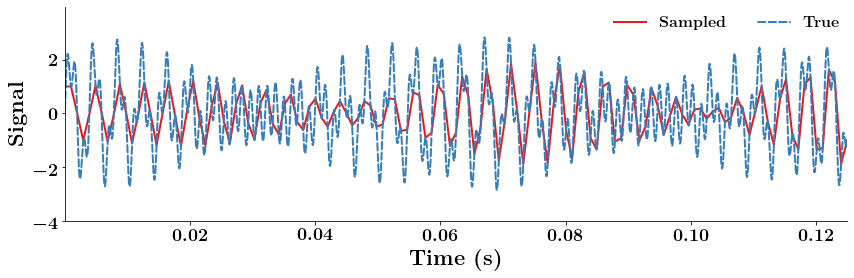

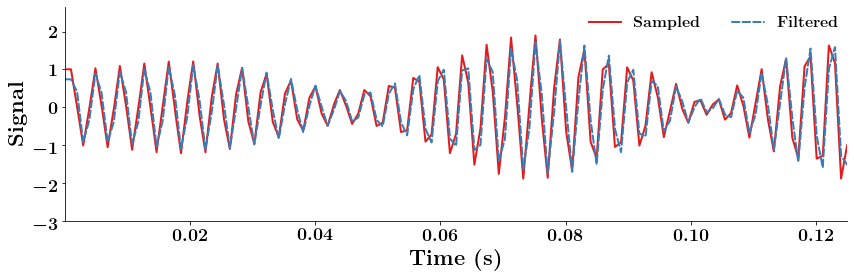

In [34]:

# responses = np.vstack((raw_fft.real,raw_fft.imag,(raw_fft * raw_fft.conj()).real))
responses = np.vstack((sampledSignal,trueSignal))
plotting.generate_plot(time,responses,
                         ['Sampled','True'],'Time (s)','Signal',showplot=True,
                         template='wide',
                         ymax=0.2,
                         save_plot=True,
                         transparent=True,
                         num_col=2,
                         folder='Figures/FFT_Example',
                         filename='raw_Signal_2',
                         file_type='png')

responses = np.vstack((sampledSignal,signalFiltered))
plotting.generate_plot(time,responses,
                         ['Sampled','Filtered'],'Time (s)','Signal',showplot=True,
                         template='wide',
                         ymax=0.2,
                         save_plot=True,
                         transparent=True,
                         num_col=2,
                         folder='Figures/FFT_Example',
                         filename='raw_Signal_2_Filtered',
                         file_type='png')

(64, 1)


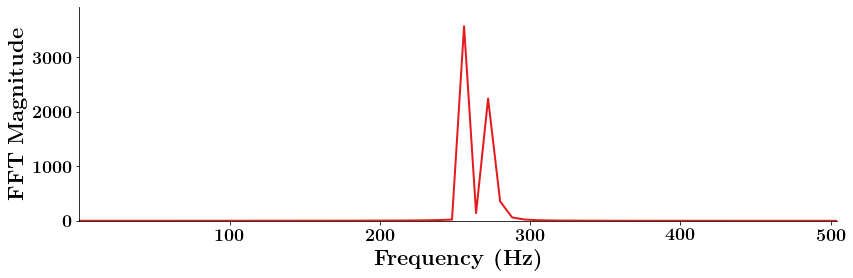

In [33]:

freq = np.fft.fftfreq(mySignal.shape[0]) * samplingRate
responses = np.vstack(((raw_fft * raw_fft.conj()).real)[:int(np.ceil(raw_fft.shape[0] / 2))])

print(responses.shape)
plotting.generate_plot(freq[:int(np.ceil(raw_fft.shape[0] / 2))],responses,
                         [''],'Frequency (Hz)','FFT Magnitude',showplot=True,
                         template='wide',
                         save_plot=True,
                         transparent=True,
                         num_col=1,
                         log_y=False,
                         folder='Figures/FFT_Example',
                         filename='Raw_FFT_Physical_Aliased',
                         file_type='png')


In [9]:
print(freq[1] - freq[0])
print(mySignal.shape)


16.0
(128,)


In [99]:
W = np.exp(-1.j * 2 * np.pi / mySignal.shape[0]) ** 1

In [89]:
# W = 2

In [90]:
w = np.array([W**i for i in range(mySignal.shape[0])])

In [276]:
W_matrix = np.vander(w,mySignal.shape[0],increasing=True)

In [277]:
W_matrix.shape

(3200, 3200)

In [278]:
dft = np.matmul(W_matrix, mySignal[...,np.newaxis])

In [279]:
dft.shape

(3200, 1)

In [280]:
np.allclose((dft * dft.conj()).flatten(),(raw_fft * raw_fft.conj()))
# (raw_fft * raw_fft.conj()).shape
# (dft * dft.conj()).shape

True

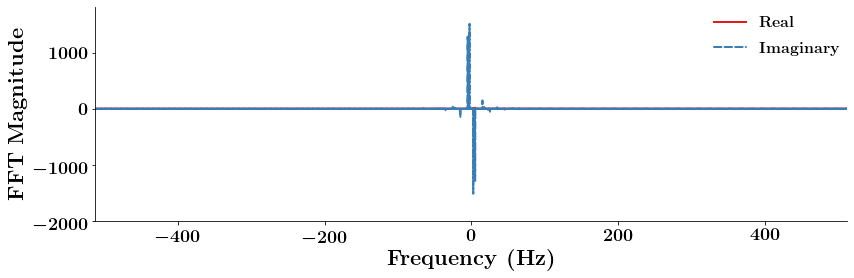

In [281]:

freq = np.fft.fftfreq(mySignal.shape[0]) * samplingRate

responses = np.hstack((dft.real,dft.imag)).T

plotting.generate_plot(freq,responses,
                         ['Real','Imaginary'],'Frequency (Hz)','FFT Magnitude',showplot=True,
                         template='wide',
                         save_plot=True,
                         transparent=True,
                         num_col=1,
                         folder='Figures/FFT_Example',
                         filename='Raw_FFT',
                         file_type='png')

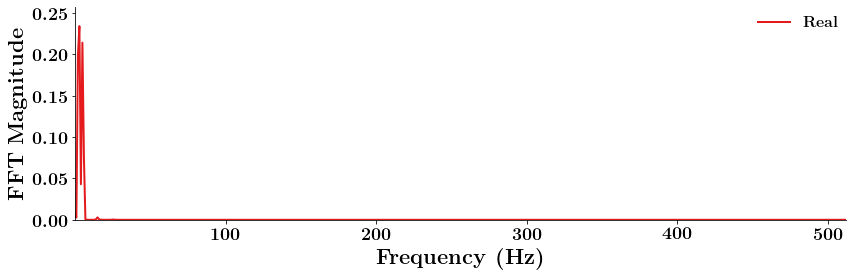

In [282]:
freqs,amps = signal.welch(mySignal, fs=samplingRate, window='hanning', nperseg=1024, noverlap=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=-1)

responses = np.hstack((amps)).T

plotting.generate_plot(freqs,responses,
                         ['Real'],'Frequency (Hz)','FFT Magnitude',showplot=True,
                         template='wide',
                         save_plot=True,
                         transparent=True,
                         num_col=1,
                         folder='Figures/FFT_Example',
                         filename='Raw_FFT',
                         file_type='png')

In [189]:
amps.shape

(257,)

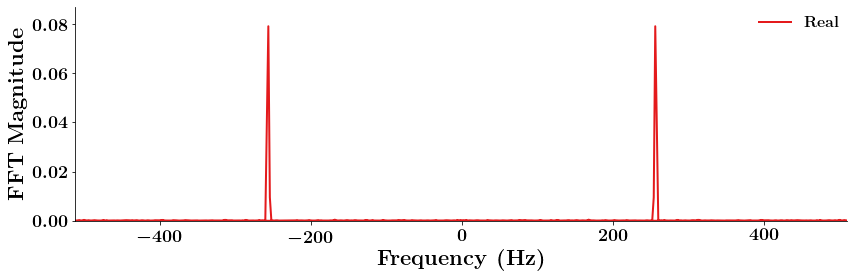

In [190]:
freqs,amps = signal.welch(mySignal, fs=samplingRate, window='hanning', nperseg=1024, noverlap=None, nfft=None, detrend='constant', return_onesided=False, scaling='density', axis=-1)

responses = np.hstack((amps)).T

plotting.generate_plot(freqs,responses,
                         ['Real'],'Frequency (Hz)','FFT Magnitude',showplot=True,
                         template='wide',
                         save_plot=True,
                         transparent=True,
                         num_col=1,
                         folder='Figures/FFT_Example',
                         filename='Raw_FFT',
                         file_type='png')

In [191]:
amps.shape

(512,)